In [138]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from itertools import product
import os 
import sys
sys.path.append(os.path.join(os.path.dirname('ea3'), 'src'))
import importlib
import ga_mlp
importlib.reload(ga_mlp)
from ga_mlp import GeneticAlgorithmMLP
import matplotlib.pyplot as plt

In [144]:
def try_crossover_rates_ga(layers, X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y,
    mutation_rate=0.1, population_size=100, generations=100, eval_every=100,
    task='regression', activation_function='tanh', runs_per_rate=3):
    
    crossover_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    for rate in crossover_rates:
        print(f"\nRunning with crossover_rate = {rate}")
        all_histories = []
        all_best_fits = []

        for run in range(runs_per_rate):
            print(f"  Run {run + 1}/{runs_per_rate}")
            ga = GeneticAlgorithmMLP(layers=layers, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
                population_size=population_size, generations=generations, mutation_rate=mutation_rate,
                crossover_rate=rate, activation_function=activation_function, task=task,
                scaler_X=scaler_X, scaler_Y=scaler_Y)

            best_ind, best_fit, history = ga.run(eval_every=eval_every)
            all_histories.append(history)
            all_best_fits.append(best_fit)

        avg_history = np.mean(all_histories, axis=0)
        std_history = np.std(all_histories, axis=0)

        results.append({
            'crossover_rate': rate,
            'mean_best_fitness': np.mean(all_best_fits),
            'std_best_fitness': np.std(all_best_fits),
            'avg_history': avg_history,
            'std_history': std_history
        })

    return results

def try_mutation_rates_ga(layers, X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y,
    crossover_rate=0.8, population_size=100, generations=100, eval_every=100,
    task='regression', activation_function='tanh', runs_per_rate=3):

    mutation_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    for rate in mutation_rates:
        print(f"\nRunning with mutation_rate = {rate}")
        all_histories = []
        all_best_fits = []

        for run in range(runs_per_rate):
            print(f"  Run {run + 1}/{runs_per_rate}")
            ga = GeneticAlgorithmMLP(layers=layers, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,
                population_size=population_size, generations=generations, mutation_rate=rate,
                crossover_rate=crossover_rate, activation_function=activation_function, task=task,
                scaler_X=scaler_X, scaler_Y=scaler_Y)

            best_ind, best_fit, history = ga.run(eval_every=eval_every)
            all_histories.append(history)
            all_best_fits.append(best_fit)

        avg_history = np.mean(all_histories, axis=0)
        std_history = np.std(all_histories, axis=0)

        results.append({
            'mutation_rate': rate,
            'mean_best_fitness': np.mean(all_best_fits),
            'std_best_fitness': np.std(all_best_fits),
            'avg_history': avg_history,
            'std_history': std_history
        })

    return results

def grid_search_ga_classification(X_train, Y_train, X_test, Y_test,
                   layers, mutation_rates, crossover_rates,
                   population_size=50, generations=100,
                   activation_function='relu', task='classification',
                   eval_every=10, runs_per_combo=3,  scaler_X=None, scaler_Y=None):

    results = []

    for mutation_rate, crossover_rate in product(mutation_rates, crossover_rates):
        #print(f"\nTesting mutation_rate={mutation_rate}, crossover_rate={crossover_rate}")
        fitness_scores = []
        f1_scores = []

        for run in range(runs_per_combo):
            #print(f"  Run {run+1}/{runs_per_combo}")
            ga = GeneticAlgorithmMLP(layers=layers, X_train=X_train, Y_train=Y_train,
                X_test=X_test, Y_test=Y_test, population_size=population_size, generations=generations,
                mutation_rate=mutation_rate, crossover_rate=crossover_rate, activation_function=activation_function,
                task=task, scaler_X=scaler_X, scaler_Y=scaler_Y)

            best_ind, best_fitness, history, f1_history = ga.run(eval_every=eval_every)

            fitness_scores.append(best_fitness)
            f1_scores.append(f1_history[-1])

        results.append({
            'mutation_rate': mutation_rate,
            'crossover_rate': crossover_rate,
            'mean_best_fitness': np.mean(fitness_scores),
            'std_best_fitness': np.std(fitness_scores),
            'mean_f1_score': np.mean(f1_scores),
            'std_f1_score': np.std(f1_scores),
            'last_f1_scores': f1_history[-1]
        })

    df_results = pd.DataFrame(results)
    return df_results


## Iris dataset

In [78]:
iris = fetch_ucirepo(id=53) 

X_iris = iris.data.features 
y_iris = iris.data.targets 
print(iris.variables) 
print(X_iris.head())
print(y_iris.head())

           name     role         type demographic  \
0  sepal length  Feature   Continuous        None   
1   sepal width  Feature   Continuous        None   
2  petal length  Feature   Continuous        None   
3   petal width  Feature   Continuous        None   
4         class   Target  Categorical        None   

                                         description units missing_values  
0                                               None    cm             no  
1                                               None    cm             no  
2                                               None    cm             no  
3                                               None    cm             no  
4  class of iris plant: Iris Setosa, Iris Versico...  None             no  
   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3

In [79]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)

X_train_iris = X_train_iris.to_numpy()
X_test_iris = X_test_iris.to_numpy()

encoder = OneHotEncoder(sparse_output=False)
Y_train_iris_onehot = encoder.fit_transform(y_train_iris.values.reshape(-1, 1))
Y_test_iris_onehot = encoder.transform(y_test_iris.values.reshape(-1, 1))

Generation 10/100, Best Fitness: 0.4823
Generation 20/100, Best Fitness: 0.4346
Generation 30/100, Best Fitness: 0.3654
Generation 40/100, Best Fitness: 0.3218
Generation 50/100, Best Fitness: 0.3218
Generation 60/100, Best Fitness: 0.2901
Generation 70/100, Best Fitness: 0.2365
Generation 80/100, Best Fitness: 0.2039
Generation 90/100, Best Fitness: 0.2039
Generation 100/100, Best Fitness: 0.0967
Best Fitness (Cross Entropy Loss) on Train set : 0.0967
Fitness (Cross Entropy Loss) on Test set: 0.1201
F1-score on Train set: 0.9750
F1-score on Test set: 1.0000


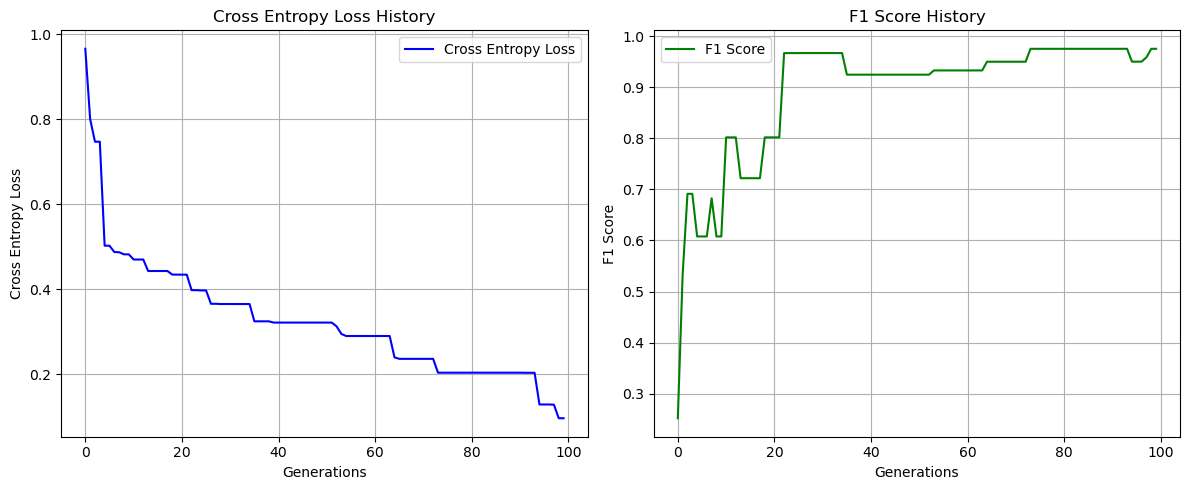

In [80]:
iris_layers = [X_train_iris.shape[1], 5, Y_train_iris_onehot.shape[1]]
iris_ga_mlp = GeneticAlgorithmMLP(layers=iris_layers, X_train=X_train_iris, Y_train=Y_train_iris_onehot,
    X_test=X_test_iris, Y_test=Y_test_iris_onehot, population_size=50, generations=100, mutation_rate=0.1,
    crossover_rate=0.8, activation_function='relu',task='classification')

best_individual_iris, best_fitness_iris, fitness_history_iris, f1_history_iris = iris_ga_mlp.run(eval_every=10)
iris_ga_mlp.plot_fitness_history(fitness_history_iris, f1_history_iris)

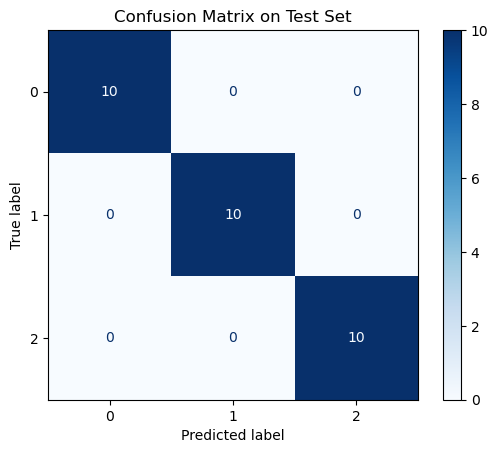

In [81]:
iris_ga_mlp.plot_test_results(best_individual_iris)

In [ ]:
mutation_rates = [0.1, 0.3, 0.5, 0.7]
crossover_rates = [0.2, 0.6, 0.8, 0.9]

iris_layers = [X_train_iris.shape[1], 5, Y_train_iris_onehot.shape[1]]

results_df = grid_search_ga_classification(X_train_iris, Y_train_iris_onehot, X_test_iris, Y_test_iris_onehot,
    layers=iris_layers, mutation_rates=mutation_rates, crossover_rates=crossover_rates,
    population_size=50, generations=100, activation_function='relu', task='classification',
    eval_every=101, runs_per_combo=3)

print(results_df)


Best Fitness (Cross Entropy Loss) on Train set : 0.1136
Fitness (Cross Entropy Loss) on Test set: 0.0922
F1-score on Train set: 0.9500
F1-score on Test set: 1.0000
Best Fitness (Cross Entropy Loss) on Train set : 0.0931
Fitness (Cross Entropy Loss) on Test set: 0.0912
F1-score on Train set: 0.9667
F1-score on Test set: 0.9666
Best Fitness (Cross Entropy Loss) on Train set : 0.1506
Fitness (Cross Entropy Loss) on Test set: 0.1227
F1-score on Train set: 0.9666
F1-score on Test set: 0.9666
Best Fitness (Cross Entropy Loss) on Train set : 0.1605
Fitness (Cross Entropy Loss) on Test set: 0.1583
F1-score on Train set: 0.9416
F1-score on Test set: 0.9666
Best Fitness (Cross Entropy Loss) on Train set : 0.1374
Fitness (Cross Entropy Loss) on Test set: 0.1609
F1-score on Train set: 0.9833
F1-score on Test set: 1.0000
Best Fitness (Cross Entropy Loss) on Train set : 0.1011
Fitness (Cross Entropy Loss) on Test set: 0.1226
F1-score on Train set: 0.9833
F1-score on Test set: 1.0000
Best Fitness (Cr

## Multimodal dataset

In [3]:
multimodal_training = pd.read_csv('./data/multimodal-large-training.csv')
multimodal_test = pd.read_csv('./data/multimodal-large-test.csv')

X_train_multimodal, y_train_multimodal = multimodal_training['x'].to_numpy(), multimodal_training['y'].to_numpy()
X_test_multimodal, y_test_multimodal = multimodal_test['x'].to_numpy(), multimodal_test['y'].to_numpy()

X_train_multimodal = X_train_multimodal.reshape(-1, 1)
X_test_multimodal = X_test_multimodal.reshape(-1, 1)
y_train_multimodal = y_train_multimodal.reshape(-1, 1)
y_test_multimodal = y_test_multimodal.reshape(-1, 1)

scaler_X, scaler_Y = MinMaxScaler(), MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_multimodal)
X_test_scaled = scaler_X.transform(X_test_multimodal)

y_train_scaled = scaler_Y.fit_transform(y_train_multimodal)
y_test_scaled = scaler_Y.transform(y_test_multimodal)

#### trying different mutation rates and crossover rates


Running with crossover_rate = 0.1
  Run 1/3
Generation 50/50, Best Fitness: 3146.8668
Best Fitness (MSE) on Train set : 3146.8668
Fitness (MSE) on Test set: 3078.7193
  Run 2/3
Generation 50/50, Best Fitness: 2462.3625
Best Fitness (MSE) on Train set : 2462.3625
Fitness (MSE) on Test set: 2399.7874
  Run 3/3
Generation 50/50, Best Fitness: 2431.4838
Best Fitness (MSE) on Train set : 2431.4838
Fitness (MSE) on Test set: 2442.2978

Running with crossover_rate = 0.3
  Run 1/3
Generation 50/50, Best Fitness: 2574.6158
Best Fitness (MSE) on Train set : 2574.6158
Fitness (MSE) on Test set: 2568.1107
  Run 2/3
Generation 50/50, Best Fitness: 3197.6651
Best Fitness (MSE) on Train set : 3197.6651
Fitness (MSE) on Test set: 3252.0336
  Run 3/3
Generation 50/50, Best Fitness: 3229.3999
Best Fitness (MSE) on Train set : 3229.3999
Fitness (MSE) on Test set: 3246.3755

Running with crossover_rate = 0.5
  Run 1/3
Generation 50/50, Best Fitness: 3250.7278
Best Fitness (MSE) on Train set : 3250.7278
F

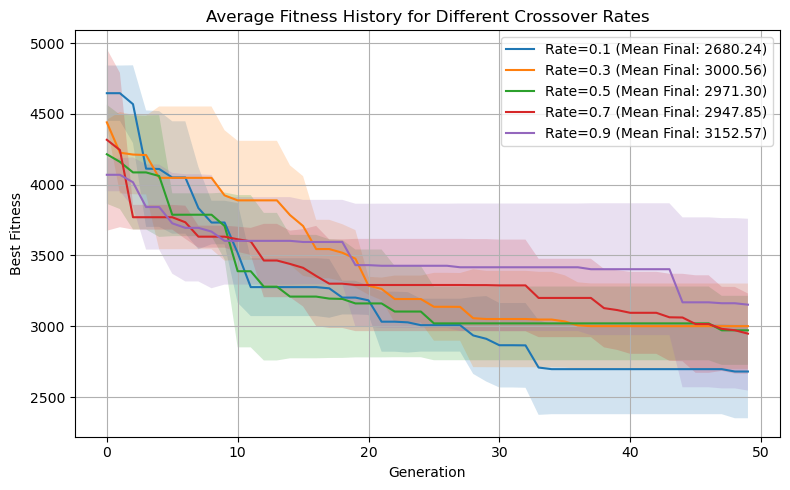

In [65]:
layers = [X_train_multimodal.shape[1], 5, 5, 5, 1]
results_cr = try_crossover_rates_ga(layers=layers,
    X_train=X_train_scaled, Y_train=y_train_scaled, X_test=X_test_scaled, Y_test=y_test_scaled, scaler_X=scaler_X,
    scaler_Y=scaler_Y, mutation_rate=0.2, population_size=100, generations=50, eval_every=50, task='regression',
    activation_function='relu')

plt.figure(figsize=(8,5))

for res in results_cr:
    generations = np.arange(len(res['avg_history']))
    mean = res['avg_history']
    std = res['std_history']
    rate = res['crossover_rate']

    plt.plot(generations, mean, label=f"Rate={rate} (Mean Final: {mean[-1]:.2f})")
    plt.fill_between(generations, mean - std, mean + std, alpha=0.2)

plt.title("Average Fitness History for Different Crossover Rates")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Running with mutation_rate = 0.1
  Run 1/3
Generation 50/50, Best Fitness: 2813.4902
Best Fitness (MSE) on Train set : 2813.4902
Fitness (MSE) on Test set: 2718.5491
  Run 2/3
Generation 50/50, Best Fitness: 3024.9476
Best Fitness (MSE) on Train set : 3024.9476
Fitness (MSE) on Test set: 3065.6899
  Run 3/3
Generation 50/50, Best Fitness: 2828.5784
Best Fitness (MSE) on Train set : 2828.5784
Fitness (MSE) on Test set: 2790.9807

Running with mutation_rate = 0.3
  Run 1/3
Generation 50/50, Best Fitness: 2765.7523
Best Fitness (MSE) on Train set : 2765.7523
Fitness (MSE) on Test set: 2727.2263
  Run 2/3
Generation 50/50, Best Fitness: 2735.8986
Best Fitness (MSE) on Train set : 2735.8986
Fitness (MSE) on Test set: 2724.6553
  Run 3/3
Generation 50/50, Best Fitness: 3372.9787
Best Fitness (MSE) on Train set : 3372.9787
Fitness (MSE) on Test set: 3403.1395

Running with mutation_rate = 0.5
  Run 1/3
Generation 50/50, Best Fitness: 2965.0062
Best Fitness (MSE) on Train set : 2965.0062
Fitn

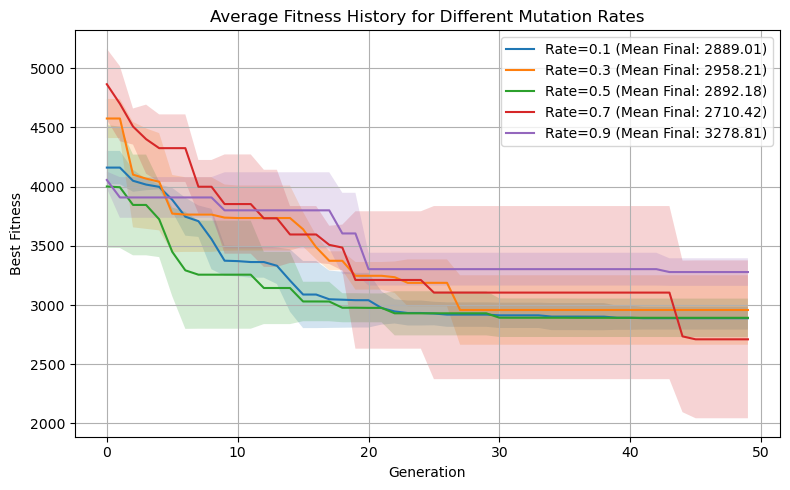

In [66]:
layers = [X_train_multimodal.shape[1], 5, 5, 5, 1]
results_mr = try_mutation_rates_ga(
    layers, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler_X, scaler_Y,
    crossover_rate=0.7, population_size=100, generations=50, eval_every=50,
    task='regression', activation_function='relu')

plt.figure(figsize=(8,5))

for res in results_mr:
    generations = np.arange(len(res['avg_history']))
    mean = res['avg_history']
    std = res['std_history']
    rate = res['mutation_rate']

    plt.plot(generations, mean, label=f"Rate={rate} (Mean Final: {mean[-1]:.2f})")
    plt.fill_between(generations, mean - std, mean + std, alpha=0.2)

plt.title("Average Fitness History for Different Mutation Rates")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### running algorithm

Generation 50/2000, Best Fitness: 2967.2393
Generation 100/2000, Best Fitness: 2489.7588
Generation 150/2000, Best Fitness: 2292.7578
Generation 200/2000, Best Fitness: 1538.3692
Generation 250/2000, Best Fitness: 1215.3519
Generation 300/2000, Best Fitness: 1124.0976
Generation 350/2000, Best Fitness: 884.3932
Generation 400/2000, Best Fitness: 852.8467
Generation 450/2000, Best Fitness: 815.4132
Generation 500/2000, Best Fitness: 808.9491
Generation 550/2000, Best Fitness: 782.1319
Generation 600/2000, Best Fitness: 765.0848
Generation 650/2000, Best Fitness: 759.1287
Generation 700/2000, Best Fitness: 758.9302
Generation 750/2000, Best Fitness: 757.1176
Generation 800/2000, Best Fitness: 750.2540
Generation 850/2000, Best Fitness: 735.4333
Generation 900/2000, Best Fitness: 729.3651
Generation 950/2000, Best Fitness: 724.6776
Generation 1000/2000, Best Fitness: 722.3059
Generation 1050/2000, Best Fitness: 721.3190
Generation 1100/2000, Best Fitness: 719.8132
Generation 1150/2000, Be

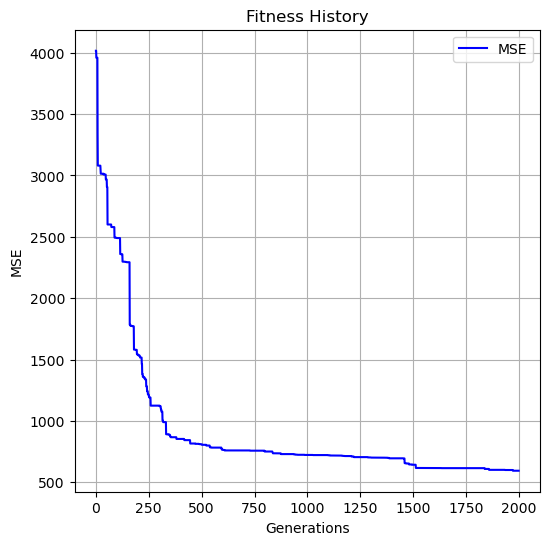

In [76]:
multimodal_layers = [X_train_multimodal.shape[1], 5, 5, 5, 1]
multimodal_ga_mlp = GeneticAlgorithmMLP(layers=multimodal_layers, X_train=X_train_scaled, Y_train=y_train_scaled,
    X_test=X_test_scaled, Y_test=y_test_scaled, population_size=200, generations=2000, mutation_rate=0.5,
    crossover_rate=0.8, activation_function='relu',task='regression', scaler_X=scaler_X, scaler_Y=scaler_Y)

best_individual_multimodal, best_fitness_multimodal, fitness_history_multimodal = multimodal_ga_mlp.run(eval_every=50, elitism_ratio=0.05)
multimodal_ga_mlp.plot_fitness_history(fitness_history_multimodal)

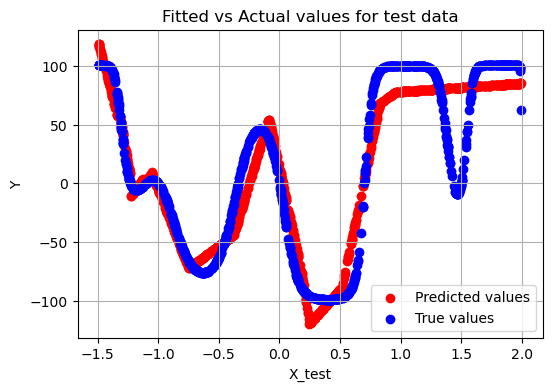

In [77]:
multimodal_ga_mlp.plot_test_results(best_individual_multimodal)

## Auto-mpg dataset

In [86]:
auto_mpg = fetch_ucirepo(id=9) 

X_mpg = auto_mpg.data.features 
y_mpg = auto_mpg.data.targets 
print(auto_mpg.variables) 
print(X_mpg.head())
print(y_mpg.head())

           name     role         type demographic description units  \
0  displacement  Feature   Continuous        None        None  None   
1           mpg   Target   Continuous        None        None  None   
2     cylinders  Feature      Integer        None        None  None   
3    horsepower  Feature   Continuous        None        None  None   
4        weight  Feature   Continuous        None        None  None   
5  acceleration  Feature   Continuous        None        None  None   
6    model_year  Feature      Integer        None        None  None   
7        origin  Feature      Integer        None        None  None   
8      car_name       ID  Categorical        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3            yes  
4             no  
5             no  
6             no  
7             no  
8             no  
   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0        

In [87]:
df = pd.concat([X_mpg, y_mpg], axis=1)
df_cleaned = df.dropna()
X_cleaned = df_cleaned[X_mpg.columns]
y_cleaned = df_cleaned[y_mpg.columns]

In [ ]:
X_train_mpg, X_test_mpg, y_train_mpg, y_test_mpg = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

without scaling

Generation 500/5000, Best Fitness: 9.8941
Generation 1000/5000, Best Fitness: 9.5683
Generation 1500/5000, Best Fitness: 9.5181
Generation 2000/5000, Best Fitness: 9.4630
Generation 2500/5000, Best Fitness: 9.4003
Generation 3000/5000, Best Fitness: 9.3593
Generation 3500/5000, Best Fitness: 9.3193
Generation 4000/5000, Best Fitness: 9.2838
Generation 4500/5000, Best Fitness: 9.2486
Generation 5000/5000, Best Fitness: 9.2094
Best Fitness (MSE) on Train set : 9.2094
Fitness (MSE) on Test set: 9.6815


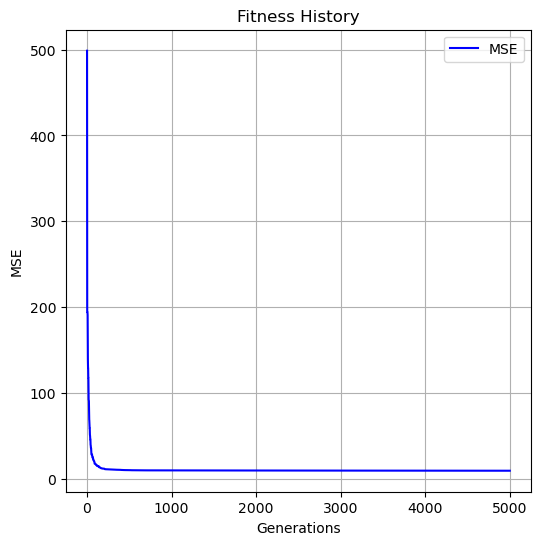

In [122]:
mpg_layers = [X_train_mpg.shape[1], 5, 1]
mpg_ga_mlp = GeneticAlgorithmMLP(layers=mpg_layers, X_train=X_train_mpg, Y_train=y_train_mpg,
    X_test=X_test_mpg, Y_test=y_test_mpg, population_size=100, generations=5000, mutation_rate=0.5,
    crossover_rate=0.8, activation_function='relu',task='regression')

best_individual_mpg, best_fitness_mpg, fitness_history_mpg = mpg_ga_mlp.run(eval_every=500, elitism_ratio=0.05)
mpg_ga_mlp.plot_fitness_history(fitness_history_mpg)

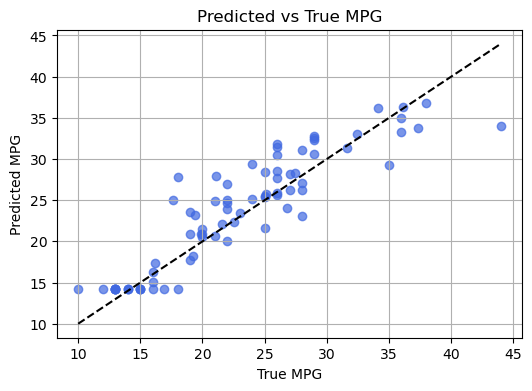

In [125]:
y_pred = mpg_ga_mlp.predict(best_individual_mpg, X_test_mpg)

plt.figure(figsize=(6, 4))
plt.scatter(y_test_mpg, y_pred, color='royalblue', alpha=0.7)
plt.plot([y_test_mpg.min(), y_test_mpg.max()],
         [y_test_mpg.min(), y_test_mpg.max()], 'k--')
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs True MPG")
plt.grid(True)
plt.show()

with scaling

In [ ]:
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_mpg)
X_test_scaled = scaler_X.transform(X_test_mpg)

y_train_scaled = scaler_y.fit_transform(y_train_mpg)
y_test_scaled = scaler_y.transform(y_test_mpg)

Generation 500/5000, Best Fitness: 11.4969
Generation 1000/5000, Best Fitness: 10.5513
Generation 1500/5000, Best Fitness: 9.4470
Generation 2000/5000, Best Fitness: 9.2735
Generation 2500/5000, Best Fitness: 9.0402
Generation 3000/5000, Best Fitness: 8.8840
Generation 3500/5000, Best Fitness: 8.5634
Generation 4000/5000, Best Fitness: 8.2256
Generation 4500/5000, Best Fitness: 8.2217
Generation 5000/5000, Best Fitness: 8.1796
Best Fitness (MSE) on Train set : 8.1796
Fitness (MSE) on Test set: 8.7479


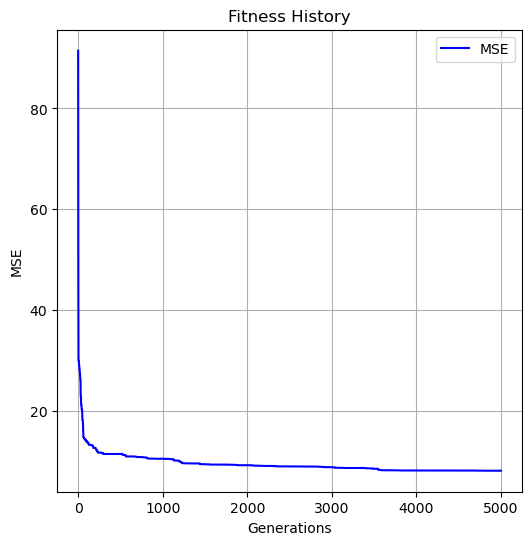

In [129]:
mpg_layers = [X_train_mpg.shape[1], 5, 1]
mpg_ga_mlp = GeneticAlgorithmMLP(layers=mpg_layers, X_train=X_train_scaled, Y_train=y_train_scaled,
    X_test=X_test_scaled, Y_test=y_test_scaled, population_size=100, generations=5000, mutation_rate=0.5,
    crossover_rate=0.8, activation_function='relu',task='regression', scaler_X=scaler_X, scaler_Y=scaler_y)

best_individual_mpg, best_fitness_mpg, fitness_history_mpg = mpg_ga_mlp.run(eval_every=500, elitism_ratio=0.05)
mpg_ga_mlp.plot_fitness_history(fitness_history_mpg)

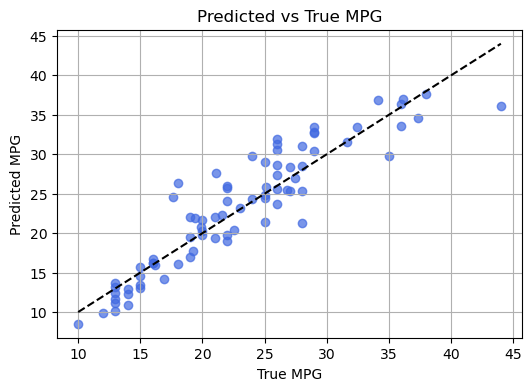

In [131]:
y_pred_scaled = mpg_ga_mlp.predict(best_individual_mpg, X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(y_test_mpg, y_pred, color='royalblue', alpha=0.7)
plt.plot([y_test_mpg.min(), y_test_mpg.max()],
         [y_test_mpg.min(), y_test_mpg.max()], 'k--')
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs True MPG")
plt.grid(True)
plt.show()

higher elitism ratio - 10%

Generation 500/5000, Best Fitness: 7.8092
Generation 1000/5000, Best Fitness: 7.6421
Generation 1500/5000, Best Fitness: 7.6161
Generation 2000/5000, Best Fitness: 7.5230
Generation 2500/5000, Best Fitness: 7.4640
Generation 3000/5000, Best Fitness: 7.4596
Generation 3500/5000, Best Fitness: 7.4585
Generation 4000/5000, Best Fitness: 7.4549
Generation 4500/5000, Best Fitness: 7.4549
Generation 5000/5000, Best Fitness: 7.4549
Best Fitness (MSE) on Train set : 7.4549
Fitness (MSE) on Test set: 7.3030


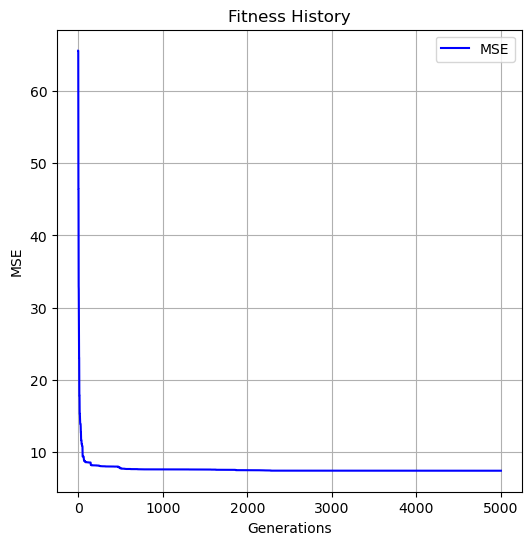

In [135]:
mpg_layers = [X_train_mpg.shape[1], 5, 1]
mpg_ga_mlp = GeneticAlgorithmMLP(layers=mpg_layers, X_train=X_train_scaled, Y_train=y_train_scaled,
    X_test=X_test_scaled, Y_test=y_test_scaled, population_size=100, generations=5000, mutation_rate=0.5,
    crossover_rate=0.8, activation_function='relu',task='regression', scaler_X=scaler_X, scaler_Y=scaler_y)

best_individual_mpg, best_fitness_mpg, fitness_history_mpg = mpg_ga_mlp.run(eval_every=500, elitism_ratio=0.1)
mpg_ga_mlp.plot_fitness_history(fitness_history_mpg)

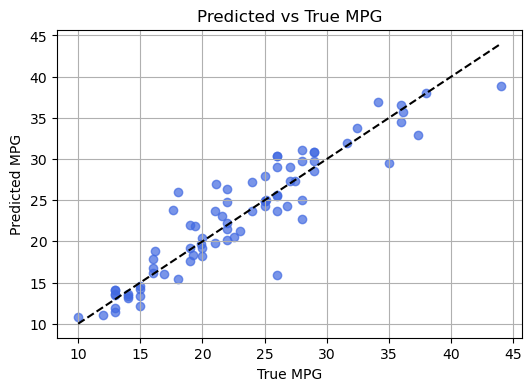

In [136]:
y_pred_scaled = mpg_ga_mlp.predict(best_individual_mpg, X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(y_test_mpg, y_pred, color='royalblue', alpha=0.7)
plt.plot([y_test_mpg.min(), y_test_mpg.max()],
         [y_test_mpg.min(), y_test_mpg.max()], 'k--')
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs True MPG")
plt.grid(True)
plt.show()